
## Project: Facial Keypoint Detection


In this project, we combine our knowledge of computer vision techniques and deep learning to build and end-to-end facial keypoint recognition system! Facial keypoints include points around the eyes, nose, and mouth on any face and are used in many applications, from facial tracking to emotion recognition. 

There are three main parts to this project:

**Part 1** : Investigating OpenCV, pre-processing, and face detection

**Part 2** : Training a Convolutional Neural Network (CNN) to detect facial keypoints

**Part 3** : Putting parts 1 and 2 together to identify facial keypoints on any image!


### Steps to Complete the Project

Each part of the notebook is further broken down into separate steps.  Feel free to use the links below to navigate the notebook.

In this project we explore a few of the many computer vision algorithms built into the OpenCV library.  This expansive computer vision library is now almost 20 years old and still growing! 

The project itself is broken down into three large parts, then even further into separate steps.  For convenience,  the links to each of these steps are provided below.

**Part 1** : Investigating OpenCV, pre-processing, and face detection

* [Step 0](#step0): Detect Faces Using a Haar Cascade Classifier
* [Step 1](#step1): Add Eye Detection
* [Step 2](#step2): De-noise an Image for Better Face Detection
* [Step 3](#step3): Blur an Image and Perform Edge Detection
* [Step 4](#step4): Automatically Hide the Identity of an Individual

**Part 2** : Training a Convolutional Neural Network (CNN) to detect facial keypoints

* [Step 5](#step5): Create a CNN to Recognize Facial Keypoints
* [Step 6](#step6): Compile and Train the Model
* [Step 7](#step7): Visualize the Loss and Answer Questions

**Part 3** : Putting parts 1 and 2 together to identify facial keypoints on any image!

* [Step 8](#step7): Build a Robust Facial Keypoints Detector (Complete the CV Pipeline)



---
<a id='step0'></a>
## Step 0: Detect Faces Using a Haar Cascade Classifier

Have you ever wondered how Facebook automatically tags images with your friends' faces?   Or how high-end cameras automatically find and focus on a certain person's face?  Applications like these depend heavily on the machine learning task known as *face detection* -  which is the task of automatically finding faces in images containing people.  

At its root face detection is a classification problem - that is a problem of distinguishing between distinct classes of things.  With face detection these distinct classes are 1) images of human faces and 2) everything else. 

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `detector_architectures` directory.


### Import Resources 

In the next python cell, we load in the required libraries for this section of the project.

In [2]:
# Import required libraries for this section
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline
import math
import cv2                     # OpenCV library for computer vision
from PIL import Image
import time 
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense
from keras.models import load_model

Next, we load in and display a test image for performing face detection.

*Note*: by default OpenCV assumes the ordering of our image's color channels are Blue, then Green, then Red.  This is slightly out of order with most image types we'll use in these experiments, whose color channels are ordered Red, then Green, then Blue.  In order to switch the Blue and Red channels of our test image around we will use OpenCV's ```cvtColor``` function.  This is a general utility function that can do other transformations too like converting a color image to grayscale, and transforming a standard color image to HSV color space.

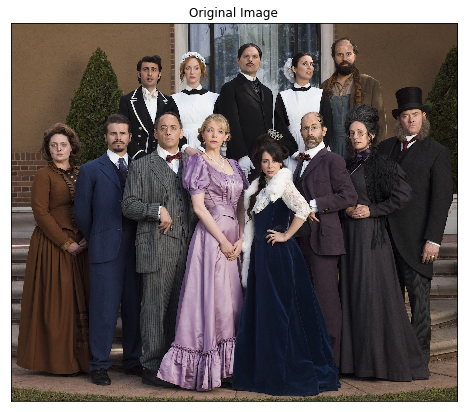

In [6]:
# Load in color image for face detection
image = cv2.imread('images/test_image_1.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot our image using subplots to specify a size and title
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_title('Original Image')
ax1.imshow(image)

There are a lot of people - and faces - in this picture.  13 faces to be exact!  In the next code cell, we demonstrate how to use a Haar Cascade classifier to detect all the faces in this test image. This face detector uses information about patterns of intensity in an image to reliably detect faces under varying light conditions. So, to use this face detector, we'll first convert the image from color to grayscale. Then, we load in the fully trained architecture of the face detector -- found in the file *haarcascade_frontalface_default.xml* - and use it on our image to find faces! We know more about the parameters of the detector from [this post](https://stackoverflow.com/questions/20801015/recommended-values-for-opencv-detectmultiscale-parameters).

Number of faces detected: 13


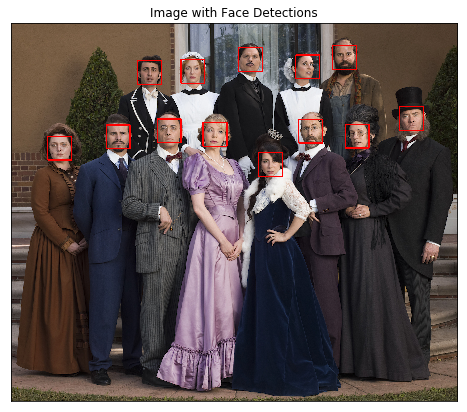

In [7]:
# Convert the RGB  image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
#scaleFactor:4 – Parameter specifying how much the image size is reduced at each image scale.
#minNeighbors:6 – Parameter specifying how many neighbors each candidate rectangle should have to retain it.
faces = face_cascade.detectMultiScale(gray, 4, 6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    #pt1 – Vertex of the rectangle.
    #pt2 – Vertex of the rectangle opposite to pt1 .
    #color – Rectangle color or brightness (grayscale image).
    #thickness – Thickness of lines that make up the rectangle. 
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    

# Display the image with the detections
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_title('Image with Face Detections')
ax1.imshow(image_with_detections)

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

---
<a id='step1'></a>

## Step 1: Add Eye Detections

There are other pre-trained detectors available that use a Haar Cascade Classifier - including full human body detectors, license plate detectors, and more.  [A full list of the pre-trained architectures can be found here](https://github.com/opencv/opencv/tree/master/data/haarcascades). 

To test your eye detector, we'll first read in a new test image with just a single face.

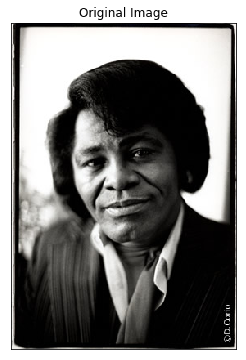

In [8]:
# Load in color image for face detection
image = cv2.imread('images/james.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the RGB image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_title('Original Image')
ax1.imshow(image)

Notice that even though the image is a black and white image, we have read it in as a color image and so it will still need to be converted to grayscale in order to perform the most accurate face detection. So, the next steps will be to convert this image to grayscale, then load OpenCV's face detector and run it with parameters that detect this face accurately.

Number of faces detected: 1


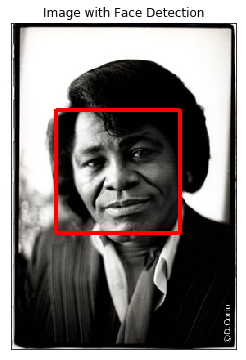

In [9]:
# Convert the RGB  image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray, 1.25, 6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    

# Display the image with the detections
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_title('Image with Face Detection')
ax1.imshow(image_with_detections)

### (IMPLEMENTATION) Add an eye detector to the current face detection setup.  

A Haar-cascade eye detector is included in the same way that the face detector was in the previous step

To set up an eye detector, use the stored parameters of the eye cascade detector, called ```haarcascade_eye.xml```, located in the `detector_architectures` subdirectory.  
**To set up the eye detector**: 

First, we make sure to give our loaded eye detector the variable name ``eye_cascade`` and give the list of eye regions we detect the variable name ``eyes``

Second, since we've already run the face detector over this image, we only search for eyes *within the rectangular face regions detected in ``faces``*.  This will minimize false detections.

Lastly, once we've run our eye detector over the facial detection region, we should display the RGB image with both the face detection boxes (in red) and your eye detections (in green) to verify that everything works as expected.

Number of eyes:  2


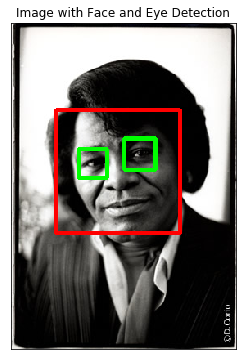

In [10]:
# Make a copy of the original image to plot rectangle detections
image_with_detections = np.copy(image)   

# Loop over the detections and draw their corresponding face detection boxes
for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h),(255,0,0), 3)  
    
#We add eye detection, using haarcascade_eye.xml, to the current face detector algorithm
#Then we loop over the eye detections and draw their corresponding boxes in green on image_with_detections
eye_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_eye.xml')

# Detect the eyes in image
eyes = eye_cascade.detectMultiScale(gray, 1.15, 6)

print("Number of eyes: ", len(eyes))
for (x, y, w, h) in eyes:
    cv2.rectangle(image_with_detections, (x, y), (x+w, y+h), (0, 255, 0), 3)

# Plot the image with both faces and eyes detected
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Image with Face and Eye Detection')
ax1.imshow(image_with_detections)

## Adding face and eye detection to our laptop camera

It's time to kick it up a notch, and add face and eye detection to our laptop's camera! 
Note that not all of the detections will be perfect. We tune the parameters of your detectors to get reasonable results, 
The below code in the function called ``laptop_camera_face_eye_detector``  will activate our laptop's camera. We will place the relevant face and eye detection code below to implement face/eye detection and mark those detections on each image frame that our camera captures.

In [19]:
### Add face and eye detection to this laptop camera function 
# Make sure to draw out all faces/eyes found in each frame on the shown video feed
# wrapper function for face/eye detection with your laptop camera
def laptop_camera_go():
    # Create instance of video capturer
    cv2.namedWindow("Face+Eye Detector [Press ESC to exit]")
    vc = cv2.VideoCapture(0)

    # Try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # Extract the pre-trained face and eye detectors from xml files
    face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_eye.xml')

    # Keep the video stream open
    while rval:
        
        # Make a copy of the original color image to plot rectangle detections
        image_with_detections = np.copy(frame)   

        # Convert the RGB video frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        
        # Detect the face(s) in the video frame
        faces = face_cascade.detectMultiScale(gray_frame, 1.25, 6)
        
        # Detect the eyes within each face rectangle
        # Note: had to bring the scaleFactor param down a bit to make this work
        for (x_face,y_face,w_face,h_face) in faces:
            # Display each face rectangle in the color image
            cv2.rectangle(image_with_detections, (x_face,y_face), (x_face+w_face,y_face+h_face), (0,0,255), 3)  
            # Limit eye detection to the face rectangle to speed things up
            eyes = eye_cascade.detectMultiScale(gray_frame[y_face:y_face+h_face, x_face:x_face+w_face], 1.10, 2)
            for (x_eye,y_eye,w_eye,h_eye) in eyes:
                # Add a green bounding box to the detections image for each eye
                # Note that eye coordinates are are relative to the face rectangle now!
                cv2.rectangle(image_with_detections, (x_face+x_eye,y_face+y_eye), (x_face+x_eye+w_eye,y_face+y_eye+h_eye), (0,255,0), 3)

        # Plot the image from camera with all the face and eye detections marked
        cv2.imshow("Face+Eye Detector [Press ESC to exit]", image_with_detections)
        
        # Exit functionality - press any key to exit laptop video
        key = cv2.waitKey(20)
        if key == 27: # Exit by pressing ESC key
            # Destroy windows 
            cv2.destroyAllWindows()
            
            # Make sure window closes on OSx
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # Read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()

In [21]:
# Call the laptop camera face/eye detector function above
laptop_camera_go()

---
<a id='step2'></a>

## Step 2: De-noise an Image for Better Face Detection

Image quality is an important aspect of any computer vision task. Typically, when creating a set of images to train a deep learning network, significant care is taken to ensure that training images are free of visual noise or artifacts that hinder object detection.  While computer vision algorithms - like a face detector - are typically trained on 'nice' data such as this, new test data doesn't always look so nice!

When applying a trained computer vision algorithm to a new piece of test data one often cleans it up first before feeding it in.  This sort of cleaning - referred to as *pre-processing* - can include a number of cleaning phases like blurring, de-noising, color transformations, etc., and many of these tasks can be accomplished using OpenCV.

In this short subsection we explore OpenCV's noise-removal functionality to see how we can clean up a noisy image, which we then feed into our trained face detector.

### Create a noisy image to work with

In the next cell, we create an artificial noisy version of the previous multi-face image.  This is a little exaggerated - we don't typically get images that are this noisy - but [image noise](https://digital-photography-school.com/how-to-avoid-and-reduce-noise-in-your-images/), or 'grainy-ness' in a digitial image - is a fairly common phenomenon.

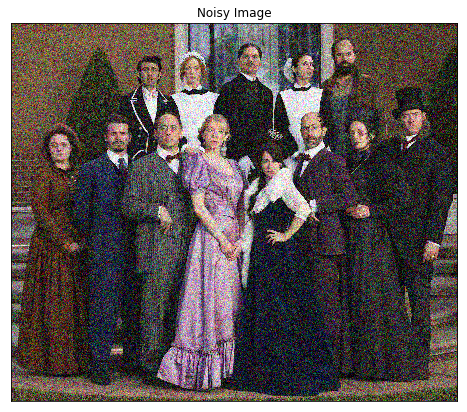

In [22]:
# Load in the multi-face test image again
image = cv2.imread('images/test_image_1.jpg')

# Convert the image copy to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Make an array copy of this image
image_with_noise = np.asarray(image)

# Create noise - here we add noise sampled randomly from a Gaussian distribution: a common model for noise
noise_level = 40
noise = np.random.randn(image.shape[0],image.shape[1],image.shape[2])*noise_level

# Add this noise to the array image copy
image_with_noise = image_with_noise + noise

# Convert back to uint8 format
#Clip (limit) the values in an array.
#Given an interval, values outside the interval are clipped to the interval edges. 
#For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1
image_with_noise = np.asarray([np.uint8(np.clip(i,0,255)) for i in image_with_noise])

# Plot our noisy image!
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_title('Noisy Image')
ax1.imshow(image_with_noise)

In the context of face detection, the problem with an image like this is that  - due to noise - we may miss some faces or get false detections.  

In the next cell we apply the same trained OpenCV detector with the same settings as before, to see what sort of detections we get.

Number of faces detected: 11


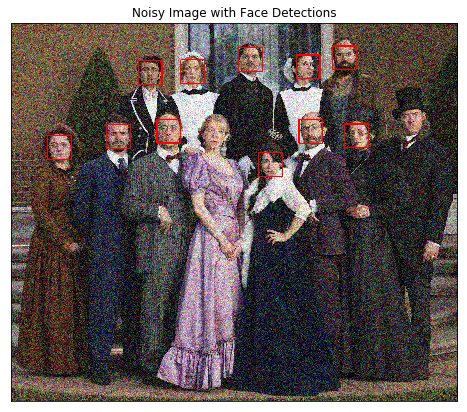

In [23]:
# Convert the RGB  image to grayscale
gray_noise = cv2.cvtColor(image_with_noise, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray_noise, 4, 6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image_with_noise)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    

# Display the image with the detections
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Noisy Image with Face Detections')
ax1.imshow(image_with_detections)

With this added noise we now miss two of the faces!

### (IMPLEMENTATION) De-noise this image for better face detection

Time to use OpenCV's built in color image [de-noising](http://docs.opencv.org/trunk/d1/d79/group__photo__denoise.html#ga21abc1c8b0e15f78cd3eff672cb6c476) functionality called ```fastNlMeansDenoisingColored``` - de-noise this image enough so that all the faces in the image are properly detected.  Once we have cleaned the image in the next cell, we use the cell that follows to run our trained face detector over the cleaned image to check out its detections.

**Note:** We keep all parameters fixed *except* `photo_render` and play around with the value of this parameter to see how it affects the resulting cleaned image.

In [35]:
## We use OpenCV's built in color image de-noising function to clean up our noisy image!
denoised_image = cv2.fastNlMeansDenoisingColored(image_with_noise, None,10,10,7, 26)

Number of faces detected: 13


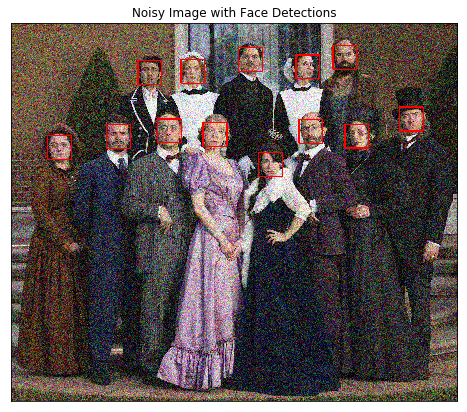

In [39]:
## We run the face detector on the de-noised image to improve your detections and display the result
# Convert the RGB  image to grayscale
gray_noise = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2GRAY)
# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray_noise, 2, 4)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image_with_noise)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)

# Display the image with the detections
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_title('Noisy Image with Face Detections')
ax1.imshow(image_with_detections)

---
<a id='step3'></a>

## Step 3: Blur an Image and Perform Edge Detection

Now that we have developed a simple pipeline for detecting faces using OpenCV we start playing around with a few fun things we can do with all those detected faces!

### Importance of Blur in Edge Detection

Edge detection is a concept that pops up almost everywhere in computer vision applications, as edge-based features (as well as features built on top of edges) are often some of the best features for e.g., object detection and recognition problems.

Edge detection is a dimension reduction technique - by keeping only the edges of an image we get to throw away a lot of non-discriminating information.  And typically the most useful kind of edge-detection is one that preserves only the important, global structures (ignoring local structures that aren't very discriminative).  So removing local structures / retaining global structures is a crucial pre-processing step to performing edge detection in an image, and blurring can do just that.  

Below is an animated gif showing the result of an edge-detected cat [taken from Wikipedia](https://en.wikipedia.org/wiki/Gaussian_blur#Common_uses), where the image is gradually blurred more and more prior to edge detection.  When the animation begins you can't quite make out what it's a picture of, but as the animation evolves and local structures are removed via blurring the cat becomes visible in the edge-detected image.

<img src="images/Edge_Image.gif" width=400 height=300/>

Edge detection is a **convolution** performed on the image itself, and you can read about Canny edge detection on [this OpenCV documentation page](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html).

### Canny edge detection

In the cell below we load in a test image, then apply *Canny edge detection* on it.  The original image is shown on the left panel of the figure, while the edge-detected version of the image is shown on the right.  Notice how the result looks very busy - there are too many little details preserved in the image before it is sent to the edge detector.  When applied in computer vision applications, edge detection should preserve *global* structure; doing away with local structures that don't help describe what objects are in the image.

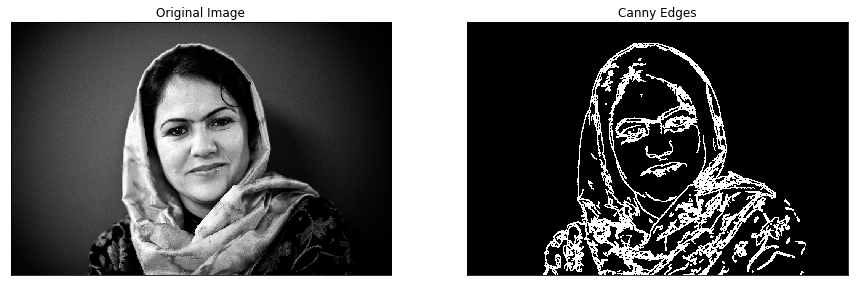

In [40]:
# Load in the image
image = cv2.imread('images/fawzia.jpg')

# Convert to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  

# Perform Canny edge detection
edges = cv2.Canny(gray,100,200)

# Dilate the image to amplify edges
edges = cv2.dilate(edges, None)

# Plot the RGB and edge-detected image
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(121)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

ax2 = fig.add_subplot(122)
ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_title('Canny Edges')
ax2.imshow(edges, cmap='gray')

Without first blurring the image, and removing small, local structures, a lot of irrelevant edge content gets picked up and amplified by the detector (as shown in the right panel above). 

### (IMPLEMENTATION) Blur the image *then* perform edge detection

In the next cell, we will repeat this experiment - blurring the image first to remove these local structures, so that only the important boudnary details remain in the edge-detected image.

Blur the image by using OpenCV's ```filter2d``` functionality - which is discussed in [this documentation page](http://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html) - and use an *averaging kernel* of width equal to 4.

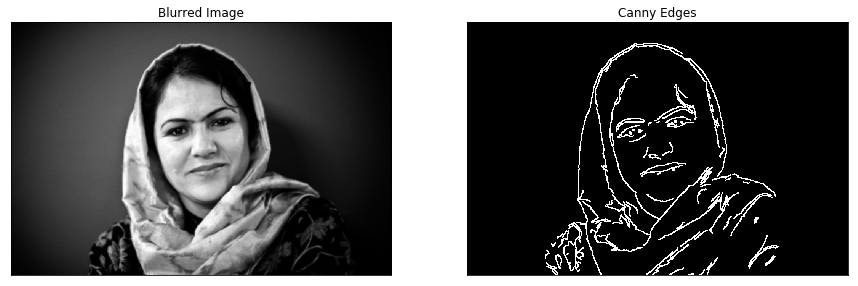

In [41]:
## We Blur the test imageusing OpenCV's filter2d functionality, 
# We use an averaging kernel, and a kernel width equal to 4
kernel = np.ones((4, 4),np.float32) / 16
blurred_image = cv2.filter2D(image, -1, kernel)

## TODO: Then perform Canny edge detection and display the output
gray = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2GRAY)  

# Perform Canny edge detection
edges = cv2.Canny(gray,100,200)

# Dilate the image to amplify edges
edges = cv2.dilate(edges, None)

# Plot the RGB and edge-detected image
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(121)
ax1.set_title('Blurred Image')
ax1.imshow(blurred_image)

ax2 = fig.add_subplot(122)
ax2.set_title('Canny Edges')
ax2.imshow(edges, cmap='gray')


---
<a id='step4'></a>

## Step 4: Automatically Hide the Identity of an Individual

If we film something like a documentary or reality TV, we must get permission from every individual shown on film before we can show their face, otherwise we need to blur it out - by blurring the face a lot (so much so that even the global structures are obscured)!  This is also true for projects like [Google's StreetView maps](https://www.google.com/streetview/) - an enormous collection of mapping images taken from a fleet of Google vehicles.  Because it would be impossible for Google to get the permission of every single person accidentally captured in one of these images they blur out everyone's faces, the detected images must automatically blur the identity of detected people.  Here's a few examples of folks caught in the camera of a Google street view vehicle.

<img src="images/streetview_example_1.jpg" width=400 height=300/>
<img src="images/streetview_example_2.jpg" width=400 height=300/>


### Read in an image to perform identity detection

Let's try this out for ourselves.  We use the face detection pipeline built above and we use the ```filter2D``` to blur and image, and use these in tandem to hide the identity of the person in the following image - loaded in and printed in the next cell. 

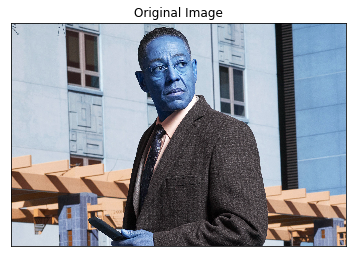

In [45]:
# Load in the image
image = cv2.imread('images/gus.jpg')

# Display the image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_title('Original Image')
ax1.imshow(image)

### (IMPLEMENTATION) Use blurring to hide the identity of an individual in an image

The idea here is to 1) automatically detect the face in this image, and then 2) blur it out!  We make sure to adjust the parameters of the *averaging* blur filter to completely obscure this person's identity.

In [46]:
def identity_protector(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
    # Detect the faces in image
    faces = face_cascade.detectMultiScale(image, 4, 6)

    # Make a copy of the orginal image to draw face detections on
    image_with_detections = np.copy(image)

    # Averaging filter
    kernel = np.ones((60, 60),np.float32) / 3600

    # Get the bounding box for each detected face
    for (x,y,w,h) in faces:
        # Add a red bounding box to the detections image
        cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
        image_with_detections[y:y+h, x:x+w, :] = cv2.filter2D(image_with_detections[y:y+h, x:x+w, :], -1, kernel)
        
    return image_with_detections

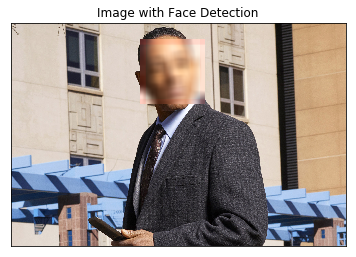

In [47]:
protected_image = identity_protector(image)

## We blur the bounding box around each detected face using an averaging filter and display the result

fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.set_title('Image with Face Detection')
ax1.imshow(protected_image)

### Addition of identity protection into our laptop camera

In this task we can add identity protection to our laptop camera, using the previously completed code where we added face detection to our laptop camera - and the task above.  We should be able to get reasonable results with little parameter tuning.

The next cell contains code in a function called ``laptop_camera_identity_hider`` that - when called  - will activate our laptop's camera. We need to place the relevant face detection and blurring code developed above in this function in order to blur faces entering our laptop camera's field of view.

Before adding anything to the function we can call it to get a hang of how it works - a small window will pop up showing us the live feed from our camera, we can press any key to close this window.


In [48]:
### Insert face detection and blurring code into the wrapper below to create an identity protector on your laptop!

def laptop_camera_go():
    # Create instance of video capturer
    cv2.namedWindow("Identity Protector [Press ESC to exit]")
    vc = cv2.VideoCapture(0)

    # Try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

    # Create a strong averaging filter kernel
    blurring_kernel = np.ones((92,92), np.float32)/(92*92)

    # Keep video stream open
    while rval:
        # Convert the RGB video frame to grayscale and detect the face(s) in it
        faces = face_cascade.detectMultiScale(cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY), 1.25, 6)
        
        # Blur the detected faces
        for (x_face,y_face,w_face,h_face) in faces:
            frame[y_face:y_face+h_face, x_face:x_face+w_face] = cv2.filter2D(frame[y_face:y_face+h_face, x_face:x_face+w_face], -1, blurring_kernel)

        # Plot image from camera with identity protected
        cv2.imshow("Identity Protector [Press ESC to exit]", frame)
        
        # Exit functionality
        key = cv2.waitKey(20)
        if key == 27: # Exit by pressing ESC key
            # Destroy windows
            cv2.destroyAllWindows()
            
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # Read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()

In [49]:
# Run laptop identity hider
laptop_camera_go()

---
<a id='step5'></a>

## Step 5: Create a CNN to Recognize Facial Keypoints

OpenCV is often used in practice with other machine learning and deep learning libraries to produce interesting results.  In this stage of the project we will create our own end-to-end pipeline - employing convolutional networks in keras along with OpenCV - to apply a "selfie" filter to streaming video and images.  

We will start by creating and then training a convolutional network that can detect facial keypoints in a small dataset of cropped images of human faces.  We then use OpenCV to expanding our detection algorithm to more general images.  What are facial keypoints?  Let's take a look at some examples.

<img src="images/keypoints_test_results.png" width=400 height=300/>

Facial keypoints (also called facial landmarks) are the small blue-green dots shown on each of the faces in the image above - there are 15 keypoints marked in each image.  They mark important areas of the face - the eyes, corners of the mouth, the nose, etc.  Facial keypoints can be used in a variety of machine learning applications from face and emotion recognition to commercial applications like the image filters popularized by Snapchat.

Below we illustrate a filter that, using the results of this section, automatically places sunglasses on people in images (using the facial keypoints to place the glasses correctly on each face).  Here, the facial keypoints have been colored lime green for visualization purposes.

<img src="images/obamas_with_shades.png" width=1000 height=1000/>

### Make a facial keypoint detector

But first things first: how can we make a facial keypoint detector?  Well, at a high level, notice that facial keypoint detection is a *regression problem*.  A single face corresponds to a set of 15 facial keypoints (a set of 15 corresponding $(x, y)$ coordinates, i.e., an output point).  Because our input data are images, we can employ a *convolutional neural network* to recognize patterns in our images and learn how to identify these keypoint given sets of labeled data.

In order to train a regressor, we need a training set - a set of facial image / facial keypoint pairs to train on.  For this we will be using [this dataset from Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/data). We've already downloaded this data and placed it in the `data` directory. Make sure that you have both the *training* and *test* data files.  The training dataset contains several thousand $96 \times 96$ grayscale images of cropped human faces, along with each face's 15 corresponding facial keypoints (also called landmarks) that have been placed by hand, and recorded in $(x, y)$ coordinates.  This wonderful resource also has a substantial testing set, which we will use in tinkering with our convolutional network.

To load in this data, run the Python cell below - notice we will load in both the training and testing sets.

The `load_data` function is in the included `utils.py` file.

In [55]:
from utils import *

# Load training set
X_train, y_train = load_data()
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

# Load testing set
X_test, _ = load_data(test=True)
print("X_test.shape == {}".format(X_test.shape))

X_train.shape == (2140, 96, 96, 1)
y_train.shape == (2140, 30); y_train.min == -0.920; y_train.max == 0.996
X_test.shape == (1783, 96, 96, 1)


### Visualize the Training Data

Execute the code cell below to visualize a subset of the training data.

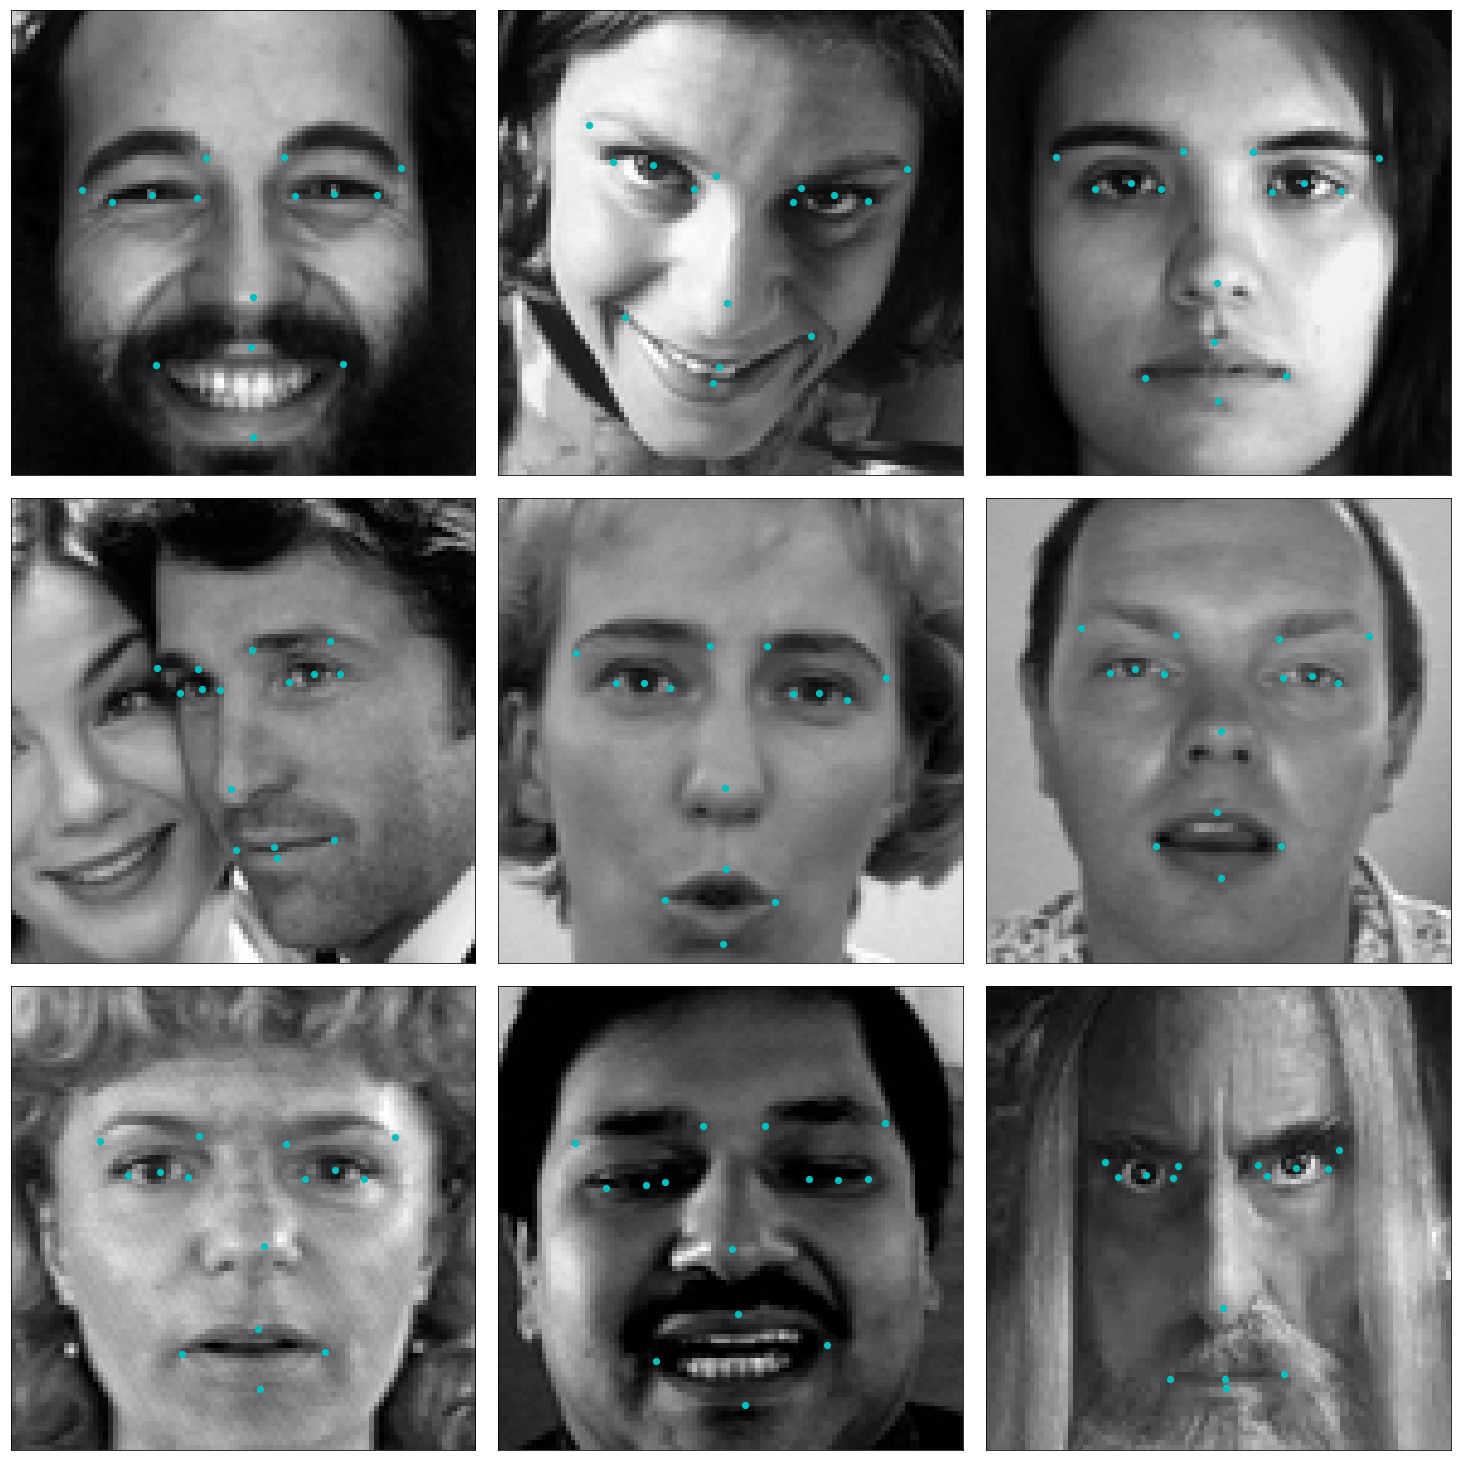

In [56]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_train[i], y_train[i], ax)

For each training image, there are two landmarks per eyebrow (**four** total), three per eye (**six** total), **four** for the mouth, and **one** for the tip of the nose.  

Review the `plot_data` function in `utils.py` to understand how the 30-dimensional training labels in `y_train` are mapped to facial locations, as this function will prove useful for your pipeline.

### (IMPLEMENTATION) Specify the CNN Architecture

In this section, we will specify a neural network for predicting the locations of facial keypoints.  We use the code cell below to specify the architecture of your neural network.  

The network accepts a $96 \times 96$ grayscale image as input, and it should output a vector with 30 entries, corresponding to the predicted (horizontal and vertical) locations of 15 facial keypoints. 

In [57]:
print(X_train.shape, X_test.shape, y_train.shape)

(2140, 96, 96, 1) (1783, 96, 96, 1) (2140, 30)


In [59]:
# Import deep learning resources from Keras
## We specify a CNN architecture
# The model should accept 96x96 pixel graysale images in
# It should have a fully-connected output layer with 30 values (2 for each facial keypoint)

model = Sequential()
model.add(Convolution2D(64, 3, 3, input_shape=(X_train.shape[1:])))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(30, activation='tanh'))


# Summarize the model
model.summary()

C:\Users\archi\Anaconda3\envs\Facial Recognition\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(96, 96, 1...)`
  import sys
C:\Users\archi\Anaconda3\envs\Facial Recognition\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 135424)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               17334400  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3870      
Total para

In [60]:
#model.load_weights('model.h5')

---
<a id='step6'></a>

## Step 6: Compile and Train the Model

After specifying the architecture, we need to compile and train the model to detect facial keypoints'

### (IMPLEMENTATION) Compile and Train the Model

We use the `compile` [method](https://keras.io/models/sequential/#sequential-model-methods) to configure the learning process.  We experiment with many [optimizers](https://keras.io/optimizers/); like (`SGD`, `RMSprop`, `Adam` etc) to choose which performs the best in this scenario

We use the `fit` [method](https://keras.io/models/sequential/#sequential-model-methods) to train the model and split a validation set by setting `validation_split=0.2` from train data. We save the returned `History` object in the `history` variable.  


In [61]:

## TODO: Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

## TODO: Save the model as model.h5
checkpointer = ModelCheckpoint(filepath='model.h5', verbose=1, 
                               save_best_only=True)
# train the model
hist = model.fit(X_train, y_train, batch_size=64, epochs=30,
          validation_split=0.2, callbacks=[checkpointer], 
          verbose=1, shuffle=True)

Train on 1712 samples, validate on 428 samples
Epoch 1/30
1712/1712 [==============================] - 237s 139ms/step - loss: 0.2698 - val_loss: 0.1036

Epoch 00001: val_loss improved from inf to 0.10361, saving model to model.h5
Epoch 2/30
1712/1712 [==============================] - 222s 130ms/step - loss: 0.2349 - val_loss: 0.0943

Epoch 00002: val_loss improved from 0.10361 to 0.09435, saving model to model.h5
Epoch 3/30
1712/1712 [==============================] - 236s 138ms/step - loss: 0.2229 - val_loss: 0.0891

Epoch 00003: val_loss improved from 0.09435 to 0.08911, saving model to model.h5
Epoch 4/30
1712/1712 [==============================] - 244s 143ms/step - loss: 0.2088 - val_loss: 0.0760

Epoch 00004: val_loss improved from 0.08911 to 0.07603, saving model to model.h5
Epoch 5/30
1712/1712 [==============================] - 244s 142ms/step - loss: 0.1963 - val_loss: 0.0620

Epoch 00005: val_loss improved from 0.07603 to 0.06199, saving model to model.h5
Epoch 6/30
1712/1

---
<a id='step7'></a>

## Step 7: Visualize the Loss and Test Predictions

### (IMPLEMENTATION)  We answer a few questions and visualize the loss

__Note:__ We add 2 convolutional layers initially to extract image features, MaxPooling for dimensionality reduction, then flatten and feed to Dense layers. I included 2 Dense layers with Dropout in between to improve generalization, rather than just 1 linear layer with no dropout.

I tested with RMSProp and and SGD for the first 10 epochs. It only took a couple seconds and very fast to verify. But the first 10 seconds of SGD and RMSProp loss decreases much slower than Adam, and some epoch offers no improvements for validation loss. Adam optimizer offers a more consistent decrease in validation loss accross epochs.


We use the code cell below to plot the training and validation loss of your neural network.  I found [this resource](http://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/) particularly useful.

In [62]:
print(hist.history.keys())

dict_keys(['val_loss', 'loss'])


dict_keys(['val_loss', 'loss'])


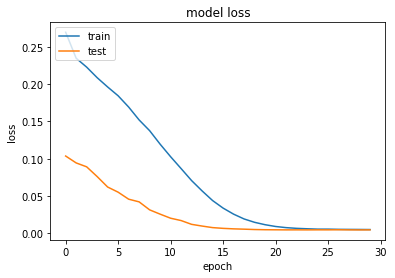

In [63]:
# We visualize the training and validation loss of your neural network
print(hist.history.keys())

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

__Observation: __ There's not much evidence of overfitting in the above plot, since train loss and test loss seems to converge at one point. Overfitting is when train loss is lower than test loss, and we don't really see it here.

### Visualize a Subset of the Test Predictions

We execute the code cell below to visualize your model's predicted keypoints on a subset of the testing images.

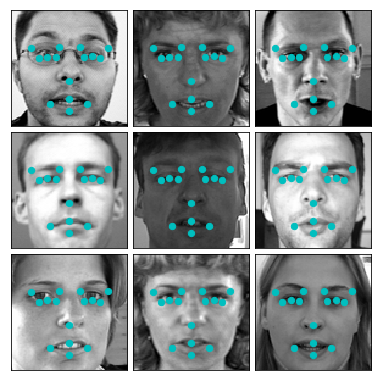

In [64]:
y_test = model.predict(X_test)
fig = plt.figure(figsize=(5,5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_test[i], y_test[i], ax)

---
<a id='step8'></a>

## Step 8: Complete the pipeline

Now with the work we did in Sections 1 and 2 of this notebook, along with our freshly trained facial keypoint detector, we can now complete the full pipeline.  That is given a color image containing a person or persons we can now 

- Detect the faces in this image automatically using OpenCV
- Predict the facial keypoints in each face detected in the image
- Paint predicted keypoints on each face detected

In this step we will do just this!  

### (IMPLEMENTATION) Facial Keypoints Detector

We use the OpenCV face detection functionality we built in previous sections to expand the functionality of our keypoints detector to color images with arbitrary size.  Our function should perform the following steps

1. Accept a color image.
2. Convert the image to grayscale.
3. Detect and crop the face contained in the image.
4. Locate the facial keypoints in the cropped image.
5. Overlay the facial keypoints in the original (color, uncropped) image.

**Note**: step 4 can be the trickiest because our convolutional network is only trained to detect facial keypoints in $96 \times 96$ grayscale images where each pixel was normalized to lie in the interval $[0,1]$, and that each facial keypoint was normalized during training to the interval $[-1,1]$.  This means - practically speaking - to paint detected keypoints onto a test face we need to perform this same pre-processing on our candidate face  - that is after detecting the face in the image we should resize it to $96 \times 96$ and normalize its values before feeding it into your facial keypoint detector.  To be shown correctly on the original image the output keypoints from our detector then need to be shifted and re-normalized from the interval $[-1,1]$ to the width and height of our detected face.

When complete we should be able to produce example images like the one below

<img src="images/obamas_with_keypoints.png" width=1000 height=1000/>

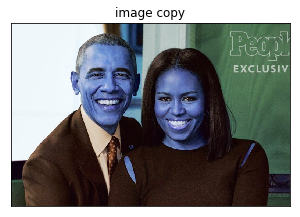

In [65]:
# Load in color image for face detection
image = cv2.imread('images/obamas4.jpg')


# Convert the image to RGB colorspace
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_copy = np.copy(image)

# plot our image
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('image copy')
ax1.imshow(image_copy)

In [77]:
### We use the face detection code we saw in Section 1 with your trained conv-net 
## Now we paint the predicted keypoints on the test image
# Convert the RGB  image to grayscale

def detect_keypoints(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

    # Detect the faces in image
    faces = face_cascade.detectMultiScale(gray, 2, 6)

    # Make a copy of the orginal image to draw face detections on
    image_with_detections = np.copy(image)

    num_face_keypoints = []
    
    # Get the bounding box for each detected face
    for (x,y,w,h) in faces:
        face_img = image_with_detections[y:y+h, x:x+w, :]

        # Pre-process
        face_reshaped = cv2.resize(face_img, (96, 96))
        gray = cv2.cvtColor(face_reshaped, cv2.COLOR_RGB2GRAY)

        gray_normalized = gray / 255.
        gray_normalized = gray_normalized[np.newaxis, :, :, np.newaxis]

        # Predict
        key_points = model.predict(gray_normalized)

        key_points = key_points * 48 + 48

        # Re-normalize
        x_coords = key_points[0][0::2]
        y_coords = key_points[0][1::2]

        x_coords = x_coords * w / 96 + x
        y_coords = y_coords * h / 96 + y

        # Add a red bounding box to the detections image
        cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)

        num_face_keypoints.append((x_coords, y_coords))
        
    return num_face_keypoints, image_with_detections

In [ ]:
print(len(keypoints))

In [ ]:
keypoints, image_with_detections = detect_keypoints(image)

for face in keypoints:
    for x, y in zip(face[0], face[1]):
        cv2.circle(image_with_detections, (x, y), 5, (0,0,255), -1)

plt.imshow(image_with_detections, cmap='gray') # plot the image

### Addition of a filter using facial keypoints to your laptop camera

Now we can add facial keypoint detection to our laptop camera. The next cell contains the basic laptop video camera function used in the previous video sections.  We combine it with the functionality we developed for keypoint detection and marking in the previous section and we wil be good to go!

In [3]:
def laptop_camera_go():
    # Create instance of video capturer
    cv2.namedWindow("Facial Keypoints [Press ESC to exit]")
    vc = cv2.VideoCapture(0)

    # Try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

    # The following ndarray will hold our CNN 1-sample input batch
    faces_96x96_cnn = np.ndarray(shape=(1,96,96,1), dtype=float, order='F')
    
    # Keep video stream open
    while rval:
        # Convert the RGB video frame to grayscale and detect the face(s) in it
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.25, 6)
        
        # Process each detected face to display bounding rectangle and facial keypoints
        for (x_face,y_face,w_face,h_face) in faces:
            # Extract a face from the GREYSCALE image
            face = gray[y_face:y_face+h_face, x_face:x_face+w_face]
            # Resize it to match our traning set image size (96x96) and normalize it to be in [0,1]
            face_96x96 = cv2.resize(face, (96,96), interpolation = cv2.INTER_CUBIC) / 255
            # Copy it in our CNN 1-sample input batch
            faces_96x96_cnn[0,:,:,0] = face_96x96
            # Predict facial keypoints
            facial_keypoints = model.predict(faces_96x96_cnn)[0]
            # Display each face rectangle in the color image
            cv2.rectangle(frame, (x_face,y_face), (x_face+w_face,y_face+h_face), (0,0,255), 3)  
            # Overlay the facial keypoints in the original (color, uncropped) image
            facial_keypoints[0::2] = facial_keypoints[0::2] * (w_face / 2) + (w_face / 2) + x_face
            facial_keypoints[1::2] = facial_keypoints[1::2] * (h_face / 2) + (h_face / 2) + y_face
            for (x_point,y_point) in zip(facial_keypoints[0::2], facial_keypoints[1::2]):
                cv2.circle(frame, (x_point, y_point), 3, (0,255,0), -1)
            
        # Plot image from camera with identity protected
        cv2.imshow("Facial Keypoints [Press ESC to exit]", frame)
        
        # Exit functionality
        key = cv2.waitKey(20)
        if key == 27: # Exit by pressing ESC key
            # Destroy windows
            cv2.destroyAllWindows()
            
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # Read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()

In [4]:
# Run your keypoint face painter
laptop_camera_go()

__Note: __ Now we play around with adding sunglasses automatically to each individual's face in an image as shown in a demonstration image below.

<img src="images/obamas_with_shades.png" width=1000 height=1000/>

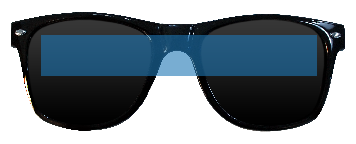

In [5]:
# Load facial landmark detector model
model = load_model('model.h5')
# Load in sunglasses image - note the usage of the special option
# cv2.IMREAD_UNCHANGED, this option is used because the sunglasses 
# image has a 4th channel that allows us to control how transparent each pixel in the image is
sunglasses = cv2.imread("images/sunglasses_4.png", cv2.IMREAD_UNCHANGED)

# Plot the image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.imshow(sunglasses)
# Below we show the (guessed) bounding rectangle for the eyes underneath the sunglasses
# We'll use the bounding rectangle to figure out how to map the glasses on the eye keypoints
# Values were obtained via experimentation
glasses_triangle_vertices = np.array([(280,220), (2800,220), (280,600)]).astype(np.float32)
ax1.add_patch(
    patches.Rectangle(
        (280, 220),   # (x,y)
        2800-280,          # width
        600-220,          # height
        alpha=0.6      # remove background
    )
)
ax1.axis('off');

The above image is placed over each individual's face using the detected eye points to determine the location of the sunglasses, and eyebrow points to determine the size that the sunglasses should be for each person (one could also use the nose point to determine this).   

In [6]:
# Print out the shape of the sunglasses image
print ('The sunglasses image has shape: ' + str(np.shape(sunglasses)))

The sunglasses image has shape: (1123, 3064, 4)


__Note:__ The above image actually has *4 channels*, not just 3.It has the usual red, blue, and green channels any color image has, with the 4th channel representing the transparency level of each pixel in the image.  Here's how the transparency channel works: the lower the value, the more transparent the pixel will become.  The lower bound (completely transparent) is zero here, so any pixels set to 0 will not be seen. 

This is how we can place this image of sunglasses on someone's face and still see the area around of their face where the sunglasses lie - because these pixels in the sunglasses image have been made completely transparent.

Lets check out the alpha channel of our sunglasses image in the next Python cell.  Note because many of the pixels near the boundary are transparent we'll need to explicitly print out non-zero values if we want to see them. 

In [7]:
# Print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]
print ('the alpha channel here looks like')
print (alpha_channel)

# Just to double check that there are indeed non-zero values
# Let's find and print out every value greater than zero
values = np.where(alpha_channel != 0)
print ('\n the non-zero values of the alpha channel look like')
print (values)

the alpha channel here looks like
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]

 the non-zero values of the alpha channel look like
(array([  17,   17,   17, ..., 1109, 1109, 1109], dtype=int64), array([ 687,  688,  689, ..., 2376, 2377, 2378], dtype=int64))


This means that when we place this sunglasses image on top of another image, we can use the transparency channel as a filter to tell us which pixels to overlay on a new image (only the non-transparent ones with values greater than zero).

One last thing: it's helpful to understand which keypoint belongs to the eyes, mouth, etc. So, in the image below, we also display the index of each facial keypoint directly on the image so that you can tell which keypoints are for the eyes, eyebrows, etc.

<img src="images/obamas_points_numbered.png" width=500 height=500/>

With this information, we're well on our way to completing this filtering task!  Now we wil place the sunglasses automatically on the individuals in the image loaded in / shown in the next Python cell.

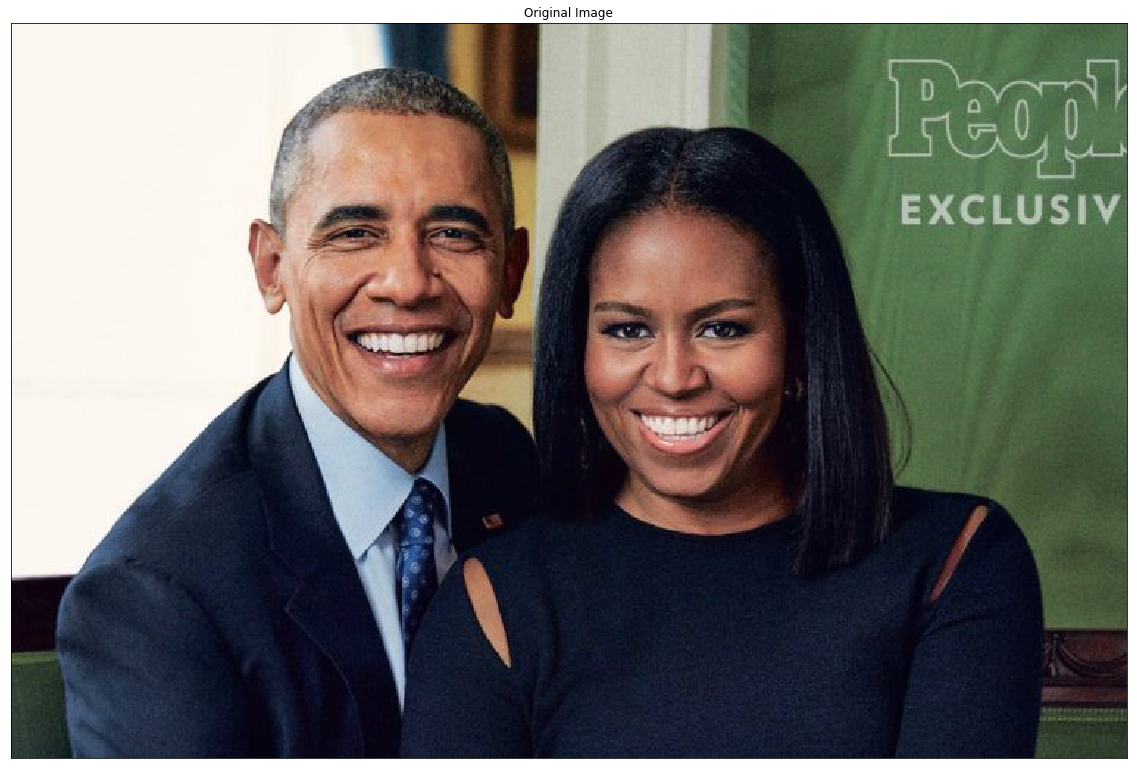

In [8]:
# Load in color image for face detection
image = cv2.imread('images/obamas4.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Original Image')
ax1.imshow(image)

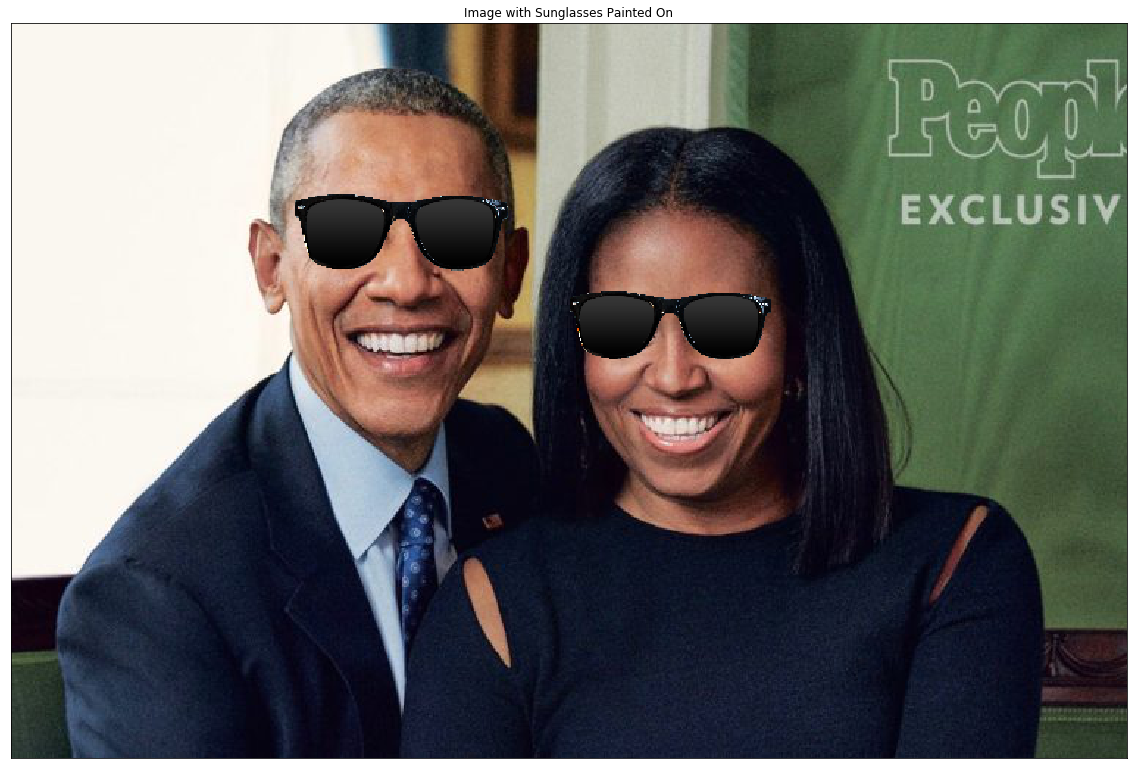

In [9]:
## We use the face detection code we saw in Section 1 with our trained conv-net to put
## sunglasses on the individuals in our test image

fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# The following ndarray will hold our CNN 1-sample input batch
faces_96x96_cnn = np.ndarray(shape=(1,96,96,1), dtype=float, order='F')

# Convert the RGB video frame to grayscale and detect the face(s) in it
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.25, 6)

# Process each detected face to display bounding rec28tangle and facial keypoints
for (x_face,y_face,w_face,h_face) in faces:
    # Extract a face from the GREYSCALE image
    face = gray[y_face:y_face+h_face, x_face:x_face+w_face]
    # Resize it to match our traning set image size (96x96) and normalize it to be in [0,1]
    face_96x96 = cv2.resize(face, (96,96), interpolation = cv2.INTER_CUBIC) / 255
    # Copy it in our CNN 1-sample input batch
    faces_96x96_cnn[0,:,:,0] = face_96x96
    # Predict facial keypoints
    facial_keypoints = model.predict(faces_96x96_cnn)[0]
    # Extract the facial keypoints for the eyes only and remap them to the original image
    facial_keypoints[0::2] = facial_keypoints[0::2] * (w_face / 2) + (w_face / 2) + x_face
    facial_keypoints[1::2] = facial_keypoints[1::2] * (h_face / 2) + (h_face / 2) + y_face
    eye_keypoints=[]
    for (x_point,y_point) in zip(facial_keypoints[0:20:2], facial_keypoints[1:20:2]):
        eye_keypoints.append((x_point, y_point))
    # Compute the bounding rectangle for the eyes
    eye_boundingRect = cv2.boundingRect(np.array(eye_keypoints).astype(np.float32))
    # Build the triangle vertices needed by cv2.getAffineTransform()
    eyes_triangle_vertices = np.array([(eye_boundingRect[0],eye_boundingRect[1]), (eye_boundingRect[0]+eye_boundingRect[2],eye_boundingRect[1]), (eye_boundingRect[0],eye_boundingRect[1]+eye_boundingRect[3])]).astype(np.float32)
    # Compute the affine transform matrix from the two sets of three points (glasses and eyes)
    map_matrix = cv2.getAffineTransform(glasses_triangle_vertices, eyes_triangle_vertices)
    # Apply the affine transformation to the glasses
    transformed_sunglasses = cv2.warpAffine(sunglasses, map_matrix, (image.shape[1], image.shape[0]))
    # Build a binary mask of the pixels where the sunglasses are
    transformed_sunglasses_mask = transformed_sunglasses[:,:,3] > 0
    # Overwrite pixels in the original image with sunglasses pixels using their mask
    image[:,:,:][transformed_sunglasses_mask] = transformed_sunglasses[:,:,0:3][transformed_sunglasses_mask]

# Plot image
ax1.set_title('Image with Sunglasses Painted On')
ax1.imshow(image)

###  Adding Sunglasses using facial keypoints to our laptop camera 

In [10]:
def laptop_camera_go():
    # Create instance of video capturer
    cv2.namedWindow("Sunglasses Painter [Press ESC to exit]")
    vc = cv2.VideoCapture(0)

    # Try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

    # The following ndarray will hold our CNN 1-sample input batch
    faces_96x96_cnn = np.ndarray(shape=(1,96,96,1), dtype=float, order='F')
    
    # Keep video stream open
    while rval:
        # Convert the RGB video frame to grayscale and detect the face(s) in it
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.25, 6)
        
        # Process each detected face to display bounding rectangle and facial keypoints
        for (x_face,y_face,w_face,h_face) in faces:
            # Extract a face from the GREYSCALE image
            face = gray[y_face:y_face+h_face, x_face:x_face+w_face]
            # Resize it to match our traning set image size (96x96) and normalize it to be in [0,1]
            face_96x96 = cv2.resize(face, (96,96), interpolation = cv2.INTER_CUBIC) / 255
            # Copy it in our CNN 1-sample input batch
            faces_96x96_cnn[0,:,:,0] = face_96x96
            # Predict facial keypoints
            facial_keypoints = model.predict(faces_96x96_cnn)[0]
            # Extract the facial keypoints for the eyes only and remap them to the original image
            facial_keypoints[0::2] = facial_keypoints[0::2] * (w_face / 2) + (w_face / 2) + x_face
            facial_keypoints[1::2] = facial_keypoints[1::2] * (h_face / 2) + (h_face / 2) + y_face
            eye_keypoints=[]
            for (x_point,y_point) in zip(facial_keypoints[0:20:2], facial_keypoints[1:20:2]):
                eye_keypoints.append((x_point, y_point))
            # Compute the bounding rectangle for the eyes
            eye_boundingRect = cv2.boundingRect(np.array(eye_keypoints).astype(np.float32))
            # Build the triangle vertices needed by cv2.getAffineTransform()
            eyes_triangle_vertices = np.array([(eye_boundingRect[0],eye_boundingRect[1]), (eye_boundingRect[0]+eye_boundingRect[2],eye_boundingRect[1]), (eye_boundingRect[0],eye_boundingRect[1]+eye_boundingRect[3])]).astype(np.float32)
            # Compute the affine transform matrix from the two sets of three points (glasses and eyes)
            map_matrix = cv2.getAffineTransform(glasses_triangle_vertices, eyes_triangle_vertices)
            # Apply the affine transformation to the glasses
            transformed_sunglasses = cv2.warpAffine(sunglasses, map_matrix, (frame.shape[1], frame.shape[0]))
            # Build a binary mask of the pixels where the sunglasses are
            transformed_sunglasses_mask = transformed_sunglasses[:,:,3] > 0
            # Overwrite pixels in the original image with sunglasses pixels using their mask
            frame[:,:,:][transformed_sunglasses_mask] = transformed_sunglasses[:,:,0:3][transformed_sunglasses_mask]
            
        # Plot image from camera with sunglasses painted on
        cv2.imshow("Sunglasses Painter [Press ESC to exit]", frame)
        
        # Exit functionality
        key = cv2.waitKey(20)
        if key == 27: # Exit by pressing ESC key
            # Destroy windows
            cv2.destroyAllWindows()
            
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # Read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()

In [11]:
# Run sunglasses painter
laptop_camera_go()